<a href="https://colab.research.google.com/github/fubotz/ICL_2024W/blob/main/FinalProject_Fabian_SCHAMBECK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICL Final Project: Finetuning a Pretrained Multilingual Model for Cognate Detection

Model: xlm-roberta-base

Dataset: custom dataset containing en-fr cognates (Frossard et al.)

Method: MASK approach

In [1]:
!pip install -q datasets
!pip install -q evaluate
!pip install -q transformers
!pip install -q torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset ##

In [3]:
!wget https://raw.githubusercontent.com/fubotz/ICL_2024W/refs/heads/main/word_pairs.json        # dataset taken from Frossard et al.

--2025-02-05 19:21:31--  https://raw.githubusercontent.com/fubotz/ICL_2024W/refs/heads/main/word_pairs.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23242 (23K) [text/plain]
Saving to: ‘word_pairs.json’

word_pairs.json     100%[===================>]  22.70K  --.-KB/s    in 0s      

2025-02-05 19:21:31 (57.9 MB/s) - ‘word_pairs.json’ saved [23242/23242]



In [4]:
import json
with open("word_pairs.json", "r") as f:
    dataset = json.load(f)
print(dataset[:10])

[{'abandon': 'abandon'}, {'abbe': 'abbé'}, {'abdomen': 'abdomen'}, {'abdominal': 'abdominal'}, {'aberration': 'aberration'}, {'abolition': 'abolition'}, {'abominable': 'abominable'}, {'absence': 'absence'}, {'absolute': 'absolu'}, {'absolution': 'absolution'}]


In [5]:
from datasets import Dataset

# Convert the dataset to a dictionary format with separate lists for English and French words
dataset_dict = {
    "word_en": [list(pair.keys())[0] for pair in dataset],      # Extract English words
    "word_fr": [list(pair.values())[0] for pair in dataset]     # Extract French words
}

# Convert to Hugging Face dataset
dataset = Dataset.from_dict(dataset_dict)

# Verify structure
print(dataset, "\n")
print(dataset[:10])

Dataset({
    features: ['word_en', 'word_fr'],
    num_rows: 492
}) 

{'word_en': ['abandon', 'abbe', 'abdomen', 'abdominal', 'aberration', 'abolition', 'abominable', 'absence', 'absolute', 'absolution'], 'word_fr': ['abandon', 'abbé', 'abdomen', 'abdominal', 'aberration', 'abolition', 'abominable', 'absence', 'absolu', 'absolution']}


## Load Model ##

In [6]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load tokenizer and model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Model for <mask> approach
pretrained_model = AutoModelForMaskedLM.from_pretrained(model_name)

# Freeze and unfreeze x encoder layers
for param in pretrained_model.base_model.parameters():
    param.requires_grad = False
for param in pretrained_model.base_model.encoder.layer[-5:].parameters():
    param.requires_grad = True

print(tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMRobertaTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}
)


## Preprocess Dataset ##

In [7]:
def preprocess_function(examples):
    """
    Tokenizes input words, replaces the French word with <mask>,
    and assigns ALL subword tokens (BytePair Encoding) of the correct target
    word as labels.

    Args:
        examples (dict): A batch of English-French cognate pairs in dictionary format:
                         {"word_en": [...], "word_fr": [...]}

    Returns:
        dict: A dictionary containing:
            - input_ids: Tokenized sentences with <mask>
            - attention_mask: Mask indicating valid tokens
            - labels: Correct token IDs for the French word at the <mask> position
    """
    # Construct masked input sentences
    masked_sentences = [
        f"In English, the word is {word_en}. En Français, le mot est {tokenizer.mask_token}."
        for word_en in examples["word_en"]
    ]

    # Tokenize input sentences
    model_inputs = tokenizer(masked_sentences, max_length=20, truncation=True, padding="max_length")

    # Find <mask> token indices
    mask_indices = [
        (torch.tensor(input_ids) == tokenizer.mask_token_id).nonzero(as_tuple=True)[0].tolist()
        for input_ids in model_inputs["input_ids"]
    ]

    # Tokenize target words (French cognates) WITHOUT special tokens
    target_tokens = tokenizer(examples["word_fr"], add_special_tokens=False)["input_ids"]

    # Initialize label tensor with -100 (ignored positions)
    model_inputs["labels"] = [[-100] * len(input_ids) for input_ids in model_inputs["input_ids"]]

    # Assign correct token IDs at the <mask> position
    for i, mask_pos in enumerate(mask_indices):
        if mask_pos and target_tokens[i]:  # Ensure <mask> is found and target word is valid
            for j, token_id in enumerate(target_tokens[i]):  # Assign all subword tokens
                if mask_pos[0] + j < len(model_inputs["labels"][i]):  # Avoid index errors
                    model_inputs["labels"][i][mask_pos[0] + j] = token_id

    return model_inputs

In [8]:
import torch

# Apply preprocessing to the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Verify structure
print(tokenized_dataset)

Map:   0%|          | 0/492 [00:00<?, ? examples/s]

Dataset({
    features: ['word_en', 'word_fr', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 492
})


In [9]:
import random

# Shuffle the dataset
tokenized_dataset = tokenized_dataset.shuffle(seed=24)

# Compute split sizes
total_size = len(tokenized_dataset)
train_size = int(0.7 * total_size)      # 70% training
val_size = int(0.2 * total_size)        # 20% validation
test_size = total_size - (train_size + val_size)        # 10% test

# Split the dataset
train_dataset = tokenized_dataset.select(range(train_size))
val_dataset = tokenized_dataset.select(range(train_size, train_size + val_size))
test_dataset = tokenized_dataset.select(range(train_size + val_size, total_size))

# Verify splits
print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Total samples: 492
Training samples: 344
Validation samples: 98
Test samples: 50


In [10]:
# Get a sample processed example
example = tokenized_dataset[0]

# Decode back to text to verify tokenization
decoded_input = tokenizer.decode(example["input_ids"])
print("Tokenized Input:", decoded_input)
print("Labels (Token IDs):", example["labels"])

# Decode the tokenized labels to check if they correctly represent the French word
decoded_label_tokens = tokenizer.convert_ids_to_tokens([id for id in example["labels"] if id != -100])
print("Decoded Label Tokens:", decoded_label_tokens)

Tokenized Input: <s> In English, the word is bis. En Français, le mot est<mask> .</s><pad>
Labels (Token IDs): [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2464, -100, -100, -100, -100]
Decoded Label Tokens: ['▁bis']


## Evaluate Pretrained Model ##

In [11]:
# Define the evaluation function
def evaluate_mask_accuracy(model, test_dataset, tokenizer, top_k=5):
    """
    Evaluates the accuracy of a masked language model on a cognate dataset.

    Args:
        model: The pretrained or fine-tuned masked language model.
        test_dataset: Hugging Face tokenized dataset with masked inputs.
        tokenizer: The tokenizer corresponding to the model.
        top_k (int): Number of top predictions to consider for accuracy.

    Returns:
        float: Accuracy of the model on the dataset.
    """
    correct_predictions = 0
    total_samples = len(test_dataset)

    for i in range(total_samples):
        # Get tokenized input and expected labels
        example = test_dataset[i]
        input_ids = torch.tensor(example["input_ids"]).unsqueeze(0)  # Add batch dimension
        labels = example["labels"]  # Token IDs for masked French word(s)
        attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0)  # Ensure padding is properly masked

        # Find the <mask> token index
        mask_token_index = (input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)

        if len(mask_token_index[0]) == 0:  # If no <mask> token is found
            print(f"Error: No {tokenizer.mask_token} token found in instance {i+1}")
            continue

        mask_token_index = mask_token_index[1]  # Get index positions of <mask> token

        # Forward pass through the model
        with torch.no_grad():
            outputs = model(input_ids)
        logits = outputs.logits  # Prediction scores for each token in vocabulary

        # Get top-k predictions for each masked token
        mask_token_logits = logits[0, mask_token_index, :]
        top_k_tokens = torch.topk(mask_token_logits, k=top_k, dim=-1).indices.tolist()

        # Decode predictions into words
        predicted_words = [[tokenizer.decode([token]).strip() for token in top_k] for top_k in top_k_tokens]

        # Decode and format the expected French word
        expected_tokens = [id for id in labels if id != -100]  # Remove ignored tokens
        expected_word_pieces = tokenizer.convert_ids_to_tokens(expected_tokens)
        expected_word = "".join([piece.lstrip("▁") for piece in expected_word_pieces])  # Concatenate and remove '▁'


        # Log predictions
        print(f"Instance {i+1}:")
        print(f"    Tokenized Input: {tokenizer.decode(example['input_ids'])}")
        print(f"    Expected French word: {expected_word}")
        print(f"    Predicted MASK words (Top-{top_k}): {predicted_words}\n")

        # Check if all expected subword tokens are predicted in top-k
        if any(expected_word in pred_list for pred_list in predicted_words):
            correct_predictions += 1

    # Compute accuracy
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
    return accuracy


# Evaluate the accuracy of pretrained model
accuracy = evaluate_mask_accuracy(pretrained_model, test_dataset, tokenizer, top_k=5)
print(f"Accuracy of the model: {accuracy:.2%}")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Instance 1:
    Tokenized Input: <s> In English, the word is habitation. En Français, le mot est<mask> .</s>
    Expected French word: habitation
    Predicted MASK words (Top-5): [['logement', 'maison', ':', ':', 'habitat']]

Instance 2:
    Tokenized Input: <s> In English, the word is journalist. En Français, le mot est<mask> .</s><pad>
    Expected French word: journaliste
    Predicted MASK words (Top-5): [['reporter', 'journalist', 'avocat', 'directeur', 'magistrat']]

Instance 3:
    Tokenized Input: <s> In English, the word is longitude. En Français, le mot est<mask> .</s>
    Expected French word: longitude
    Predicted MASK words (Top-5): [['longitud', 'de', 'long', 'longueur', 'angle']]

Instance 4:
    Tokenized Input: <s> In English, the word is ceremony. En Français, le mot est<mask> </s>
    Expected French word: cérémonie
    Predicted MASK words (Top-5): [['cérémonie', ':', ':', '.', '']]

Instance 5:
    Tokenized Input: <s> In English, the word is aberration. En Fran

## Finetune Model ##

In [12]:
import evaluate
import numpy as np

# Load accuracy metric
accuracy = evaluate.load("accuracy")

# Define metric computation function
def compute_metrics(eval_pred):
    """
    Computes accuracy during validation by ignoring padding tokens.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Flatten predictions and labels (remove -100 labels)
    flattened_predictions = []
    flattened_labels = []

    for pred, label in zip(predictions, labels):
        for p, l in zip(pred, label):
            if l != -100:       # Ignore padding token labels
                flattened_predictions.append(p)
                flattened_labels.append(l)

    return accuracy.compute(predictions=flattened_predictions, references=flattened_labels)

In [13]:
from transformers import TrainingArguments, Trainer

# Define training arguments
arguments = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/cognate_trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=8,
    num_train_epochs=6,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    gradient_accumulation_steps=2,
    weight_decay=0.03,
    load_best_model_at_end=True,
    report_to='none',
    seed=224
)

# Initialize the Trainer
trainer = Trainer(
    model=pretrained_model,
    args=arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,       # NB: change for test
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,12.198500,3.144633,0.514286


Epoch,Training Loss,Validation Loss,Accuracy
1,12.198500,3.144633,0.514286
2,7.001100,2.781941,0.531429
3,5.109900,2.719883,0.565714
4,4.999700,2.642135,0.577143
5,4.898700,2.641675,0.577143
6,3.888600,2.659819,0.577143


There were missing keys in the checkpoint model loaded: ['lm_head.decoder.weight', 'lm_head.decoder.bias'].


TrainOutput(global_step=66, training_loss=5.975345524874601, metrics={'train_runtime': 360.8972, 'train_samples_per_second': 5.719, 'train_steps_per_second': 0.183, 'total_flos': 21275248838400.0, 'train_loss': 5.975345524874601, 'epoch': 6.0})

In [15]:
# Save the trained model
output_dir = "/content/drive/MyDrive/Colab Notebooks/cognate_trainer_best_model"
trainer.save_model(output_dir)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)

print("\nTest Results:")
print(test_results)


Test Results:
{'eval_loss': 2.6694769859313965, 'eval_accuracy': 0.5408163265306123, 'eval_runtime': 4.7135, 'eval_samples_per_second': 10.608, 'eval_steps_per_second': 0.849, 'epoch': 6.0}


In [16]:
# Load finetuned model
finetuned_model = AutoModelForMaskedLM.from_pretrained(output_dir)

## Evaluate Finetuned Model ##

In [17]:
# Evaluate the accuracy of finetuned model
accuracy = evaluate_mask_accuracy(finetuned_model, test_dataset, tokenizer, top_k=5)
print(f"Accuracy of the model: {accuracy:.2%}")

Instance 1:
    Tokenized Input: <s> In English, the word is habitation. En Français, le mot est<mask> .</s>
    Expected French word: habitation
    Predicted MASK words (Top-5): [['', 'é', 'a', 'dépend', 'à']]

Instance 2:
    Tokenized Input: <s> In English, the word is journalist. En Français, le mot est<mask> .</s><pad>
    Expected French word: journaliste
    Predicted MASK words (Top-5): [['journalist', 'technicien', 'média', 'photograph', '']]

Instance 3:
    Tokenized Input: <s> In English, the word is longitude. En Français, le mot est<mask> .</s>
    Expected French word: longitude
    Predicted MASK words (Top-5): [['longitud', 'long', 'longueur', '', 'lo']]

Instance 4:
    Tokenized Input: <s> In English, the word is ceremony. En Français, le mot est<mask> </s>
    Expected French word: cérémonie
    Predicted MASK words (Top-5): [['ce', 'cé', 'é', '', 'sé']]

Instance 5:
    Tokenized Input: <s> In English, the word is aberration. En Français, le mot est<mask> .</s>
  

## Visualization ##

<ipython-input-18-d3c8e45ce994>:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, cmap="coolwarm")


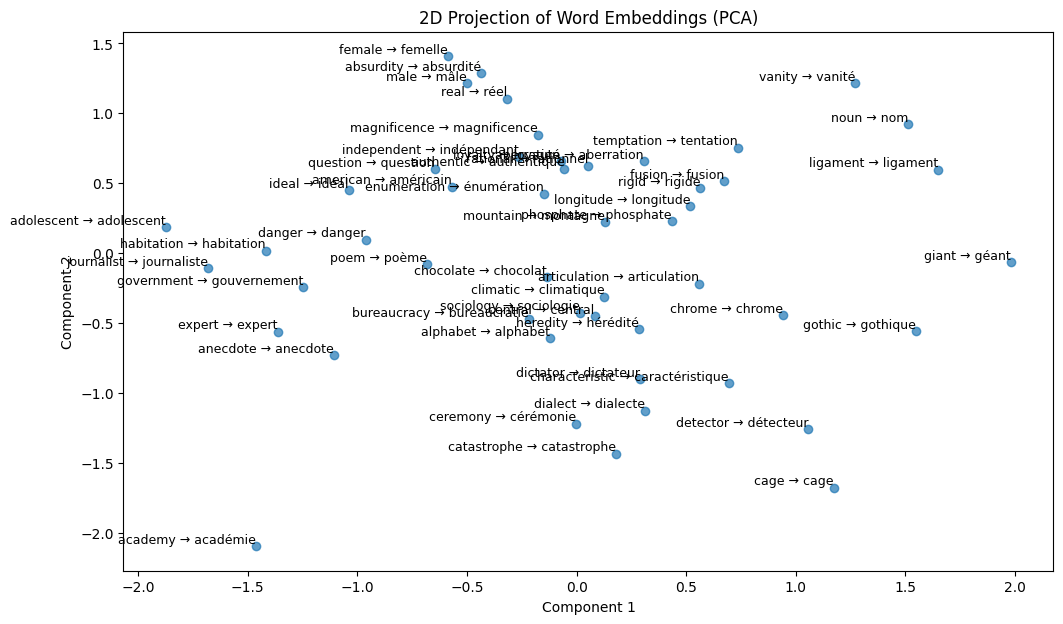

<ipython-input-18-d3c8e45ce994>:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, cmap="coolwarm")


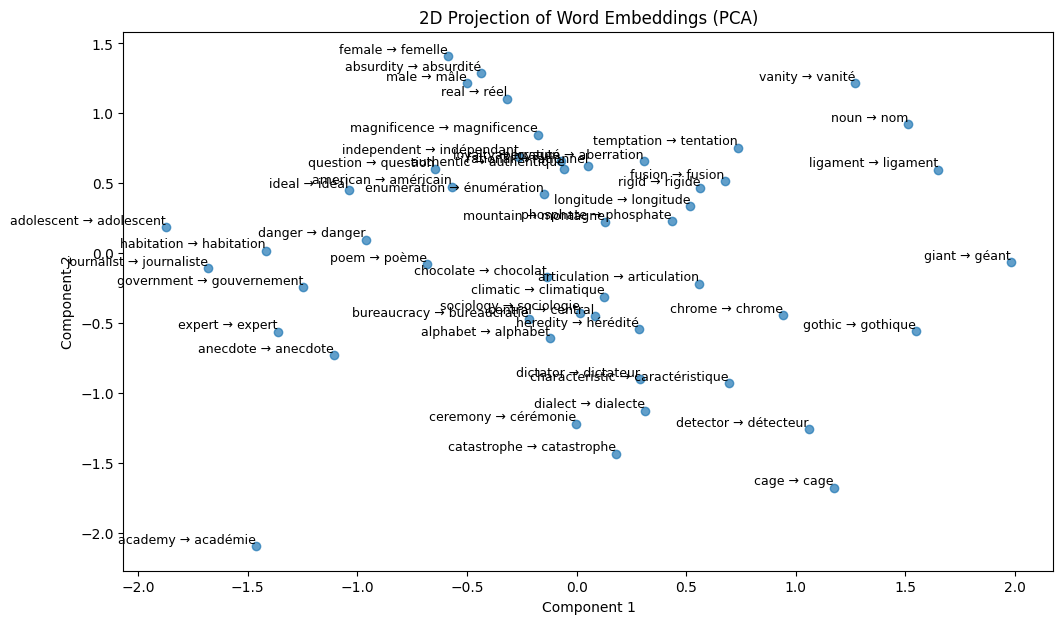

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pretrained_model.config.output_hidden_states = True
finetuned_model.config.output_hidden_states = True

def visualize_embeddings_2D(model, tokenizer, dataset, method="pca", sample_size=50):
    """
    Visualizes word embeddings from the model in 2D space using PCA or t-SNE.

    Args:
        model: The masked language model (pretrained or fine-tuned).
        tokenizer: Tokenizer corresponding to the model.
        dataset: Hugging Face Dataset with preprocessed inputs.
        method (str): Dimensionality reduction method ("pca" or "tsne").
        sample_size (int): Number of word pairs to sample for visualization.
    """
    words = []
    embeddings = []

    # Sample a subset for visualization
    dataset = dataset.select(range(min(sample_size, len(dataset))))

    for example in dataset:
        input_ids = torch.tensor(example["input_ids"]).unsqueeze(0)  # Add batch dimension
        attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0)

        # Find the <mask> token index
        mask_token_index = (input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)

        if len(mask_token_index[0]) == 0:
            continue  # Skip instances where no <mask> token is found

        mask_token_index = mask_token_index[1]  # Extract index positions

        # Extract model embeddings
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
            hidden_states = outputs.hidden_states[-1]  # Get the last hidden layer

        # Extract embeddings for <mask> token (mean over all masked positions)
        mask_embeddings = hidden_states[0, mask_token_index, :].mean(dim=0).numpy()

        embeddings.append(mask_embeddings)

        # Store words (English and French)
        words.append(f"{example['word_en']} → {example['word_fr']}")

    # Convert to NumPy array
    embeddings = np.array(embeddings)

    # Reduce dimensions
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=10, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'.")

    reduced_embeddings = reducer.fit_transform(embeddings)

    # Plot embeddings
    plt.figure(figsize=(12, 7))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, cmap="coolwarm")

    # Annotate points with word pairs
    for i, word_pair in enumerate(words):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], word_pair, fontsize=9, ha='right', va='bottom')

    plt.title(f"2D Projection of Word Embeddings ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

# Call function for both models using PCA
visualize_embeddings_2D(pretrained_model, tokenizer, test_dataset, method="pca")
visualize_embeddings_2D(finetuned_model, tokenizer, test_dataset, method="pca")